In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter

from scipy.stats import multivariate_normal

In [2]:
class HIM: 
    """
    Class for creating the Quantum Ground State of the one dimensional 
    Bosonic Harmonic Interaction Model (HIM)
    see J. Math. Phys. 26(12), 3105, (1985).
    
    Parameters
    -----------
    N - Number of Bosons.
    omega - Frequency of the single particle harmonic confinement potential.
    lambda0 - Two body interaction parameter (= gamma^2 / 2 in the paper).
    """
    def __init__(self, N = 10, omega = 1, lambda0 = 0.1):
        self.N = N
        self.dimensions = 1
        self.omega = omega
        self.lambda0 = lambda0
        self.deltaN = np.sqrt(np.power(omega,2)+N*2*lambda0)
        self.KN = np.power(self.deltaN/np.pi,(self.dimensions/4)*(self.N-1))\
                * np.power(self.omega/np.pi,(self.dimensions/4))
        self.A = (1/(4*self.N))*((self.N-1)*self.deltaN + self.omega)
        self.B = (1/(4*self.N))*(self.omega - self.deltaN)
        self.a1 = ((self.N-1.0)*(np.power(self.omega,2) + np.power(self.deltaN,2))
                + 2.0 * (np.power(self.N,2) - self.N + 1)*self.omega*self.deltaN)\
                / ((self.N-1.0)*self.omega+self.deltaN) / (4.0*self.N)
        self.a2 = (self.N-1)*np.power(self.omega-self.deltaN,2)\
                /((self.N-1.0)*self.omega+self.deltaN) / (2.0*self.N)
    def psiN(self,x):
        """ 
        The many-body wavefunction Psi(x1,x2,...,xN) 
        ---------------------------------------------
        Input - N-dimensional postion vector 
        Output - value of wavefunction 
        
        """
        if (self.N != len(x)):
            return('Wrong Input. The length of x must be {}'.format(self.N))
        wavefunction = self.KN * np.exp(- 2 * self.A * np.dot(x,x) 
                                   - 4 * self.B * (np.sum(np.sum(np.outer(x, x) - np.diag(x*x))))/2)
        return wavefunction
    def rho1(self, x, xp = 0.0, diag = True, normN = False): 
        """
        The one-body reduced density matrix
        -----------------------------------
        rho (x, xp)
        
        Input - two position values or mesh grid matrices
        Output - the density matrix over the input
        
        diag - flag to return only the boson density, i.e., x = xp
        normN - flag to normalize the boson density to N. 
        """
        if diag == True: # will return only the diagonal of the density matrix as a vector
            rho = np.exp(-self.a1*(np.power(x,2)+np.power(x,2))+self.a2*x*x)
        else: # return the full first order density matrix
            rho = np.exp(-self.a1*(np.power(x,2)+np.power(xp,2))+self.a2*x*xp)          
        rho = rho * np.power(self.deltaN * self.N * self.omega
                                              / np.pi / ((self.N-1)*self.omega+self.deltaN),self.dimensions/2)           
        if normN == True:
            rho = rho * self.N
        return rho
    def rhoN(self, x, xp = 0.0, diag = True): 
        """
        The N-body density matrix
        -------------------------
        rhoN(x1,...,xM,x1p,...,xNp)
        
        Input - two N-dimensional vectors 
        Output - value of the densiy
        
        diag - flag to output the diagonal element only, i.e., x1 = x1p, ..., xN = xNp
        """
        if diag == True:
            rhoN = np.power(self.psiN(x), 2)
        else:
            rhoN = np.power(self.KN, 2) * np.exp(-2 * self.A * (np.power(x,2)+np.power(xp,2))
                                                 - 4 * self.B * ((np.sum(np.sum(np.outer(x, x) - np.diag(x*x))))/2)
                                                 + ((np.sum(np.sum(np.outer(xp, xp) - np.diag(xp*xp))))/2))
        return rhoN 
    def singleshot(self, numshots = 1, xmin = -2.0, xmax = +2.0):
        """
        Single-shot implementation directly from the N-body density
        using rejection sampling. The random samples are takien from 
        the multivariate normal distribution. For more than a few particles
        this works TERRIBLE !!! 
        """
        covmat = np.eye(self.N)/(self.deltaN)
        rv = multivariate_normal(mean=np.zeros(self.N),
                                 cov=covmat, allow_singular=False)
        M = np.power(self.KN,2)
        sample_size =  (max(1,int(1.0/M))*numshots,self.N)
        #coordinate_sample = (xmax - xmin) * np.random.random_sample(sample_size) + xmin
        coordinate_sample = rv.rvs(sample_size[0])
        p = np.random.random_sample(sample_size[0])
        f = np.zeros_like(p)
        for i in range(sample_size[0]):
        #    f[i] = self.rhoN(coordinate_sample[i,:])
            f[i] = self.rhoN(coordinate_sample[i]) / rv.pdf(coordinate_sample[i])
        M = np.power(self.KN,2)*(np.power(2*np.pi,self.N/2)*np.sqrt(np.linalg.det(covmat)))
        idx = (p <= f/M) # rejection sampling
        sshot = coordinate_sample[idx]
        print('Estimated Sampling Efficency={:3.2f}%'.format(100*sshot.shape[0]/coordinate_sample.shape[0]))
        return sshot
        


In [3]:
system = HIM(N = 10, omega = 1, lambda0 = 0.1);
#print(system.__doc__)

Estimated Sampling Efficency=4.32%


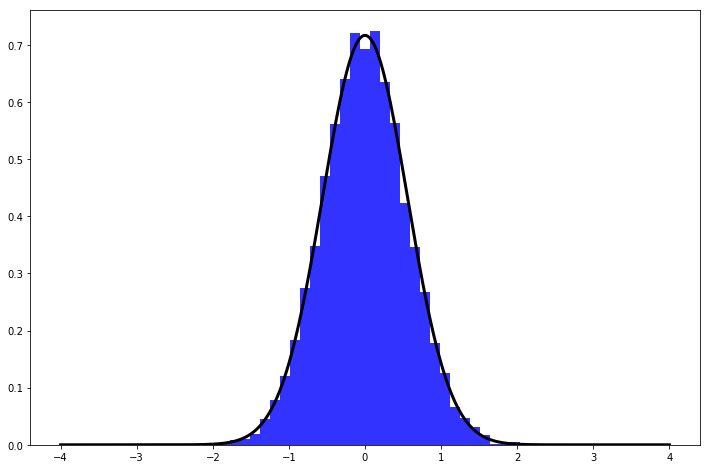

In [6]:
sshot = system.singleshot(numshots = 1000)
x = np.linspace(-4,4,512,endpoint=True)
plt.subplots(figsize = (12,8))
plt.hist(sshot.ravel(),normed = 1, bins = 32, alpha = 0.8, histtype='stepfilled', linewidth = 3, color = 'b');
plt.plot(x,  system.rho1(x), linewidth = 3, color = 'k');